# Current Topics and Projects
## Analysis

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import MNLogit
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics
from tabulate import tabulate
from pystout import pystout


In [3]:
#!pip install pystout

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
data = pd.read_csv('Data/comments_final.csv')
data_videos = pd.read_csv('C:/Users/Raphaela/Documents/MA_Studium/2. Semester/Current topics in Social Data Science/data/videos.csv')

In [7]:
data = pd.read_csv('Data/comments_final.csv')
data['toxicity'].corr(data['prob_neg'])

0.2773784421232092

In [15]:

data_videos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154122 entries, 0 to 154121
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   commentID        154122 non-null  object 
 1   text             154122 non-null  object 
 2   publishedAt      154122 non-null  object 
 3   authorID         154122 non-null  object 
 4   likeCount        154122 non-null  int64  
 5   totalReplyCount  154122 non-null  int64  
 6   parentID         154122 non-null  object 
 7   videoID          154122 non-null  object 
 8   channelId        154122 non-null  object 
 9   username         154074 non-null  object 
 10  threat           154121 non-null  float64
 11  toxicity         154121 non-null  float64
 12  identity_attack  154121 non-null  float64
 13  insult           154121 non-null  float64
 14  severe_toxicity  154121 non-null  float64
 15  sentiment        154122 non-null  object 
 16  prob_pos         154122 non-null  floa

### Research Question 1: 
Do YouTube comments on German political YouTube accounts from the left, middle, and right exhibit significant differences in polarity and toxicity

In [11]:
data["toxicity"].describe()

count    154121.000000
mean          0.391028
std           0.260157
min           0.000001
25%           0.125806
50%           0.378279
75%           0.598848
max           1.000000
Name: toxicity, dtype: float64

In [60]:
# prepare variabels for model
X = data[['toxicity', 'prob_neg']]
y = data['channelName']

In [61]:
# check for missing values
missing_values = X.isnull().sum()
print(missing_values)

# replace NA with mean
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

toxicity    1
prob_neg    0
dtype: int64


In [72]:
# add a constant to the independent variables
X = sm.add_constant(X)

# fit the multinomial logistic regression model
model = MNLogit(y, X)
result = model.fit()

print(result.summary().as_latex())

Optimization terminated successfully.
         Current function value: 0.537516
         Iterations 6
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}           &   channelName    & \textbf{  No. Observations:  } &   154122    \\
\textbf{Model:}                   &     MNLogit      & \textbf{  Df Residuals:      } &   154116    \\
\textbf{Method:}                  &       MLE        & \textbf{  Df Model:          } &        4    \\
\textbf{Date:}                    & Tue, 22 Aug 2023 & \textbf{  Pseudo R-squ.:     } &  0.01152    \\
\textbf{Time:}                    &     11:01:12     & \textbf{  Log-Likelihood:    } &   -82843.   \\
\textbf{converged:}               &       True       & \textbf{  LL-Null:           } &   -83808.   \\
\textbf{Covariance Type:}         &    nonrobust     & \textbf{  LLR p-value:       } &    0.000    \\
\bottomrule
\end{tabular}
\begin{tabular}{ccccccc}
 \textbf{channelName=DW Deutsch}  & \textbf{coef} & \textbf{std err} & \textbf{z

In [74]:
for table in result.summary().tables:
    print(table.as_latex_tabular())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}   &   channelName    & \textbf{  No. Observations:  } &  154122   \\
\textbf{Model:}           &     MNLogit      & \textbf{  Df Residuals:      } &  154116   \\
\textbf{Method:}          &       MLE        & \textbf{  Df Model:          } &       4   \\
\textbf{Date:}            & Tue, 22 Aug 2023 & \textbf{  Pseudo R-squ.:     } & 0.01152   \\
\textbf{Time:}            &     11:03:27     & \textbf{  Log-Likelihood:    } &  -82843.  \\
\textbf{converged:}       &       True       & \textbf{  LL-Null:           } &  -83808.  \\
\textbf{Covariance Type:} &    nonrobust     & \textbf{  LLR p-value:       } &   0.000   \\
\bottomrule
\end{tabular}
%\caption{MNLogit Regression Results}
\end{center}
\begin{center}
\begin{tabular}{ccccccc}
\toprule
 \textbf{channelName=DW Deutsch}  & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\bottomrule
\end{tabular

### Check conditions for logistic regression

eval_env: 1
eval_env: 1
eval_env: 1
channelName       DW Deutsch                     Jung & Naiv             
                       const        x1        x2       const        x1   
channelName                                                              
DW Deutsch  const   0.000331 -0.000539 -0.000147    0.000030 -0.000045  \
            x1     -0.000539  0.002220 -0.000320   -0.000045  0.000141   
            x2     -0.000147 -0.000320  0.000641   -0.000011 -0.000024   
Jung & Naiv const   0.000030 -0.000045 -0.000011    0.000312 -0.000510   
            x1     -0.000045  0.000141 -0.000024   -0.000510  0.002133   
            x2     -0.000011 -0.000024  0.000048   -0.000140 -0.000304   

channelName                  
                         x2  
channelName                  
DW Deutsch  const -0.000011  
            x1    -0.000024  
            x2     0.000048  
Jung & Naiv const -0.000140  
            x1    -0.000304  
            x2     0.000606  


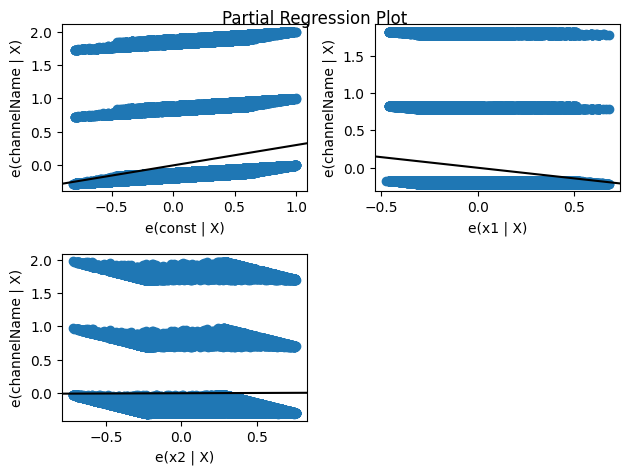

In [8]:
# 1. Linearity of Log-Odds
sm.graphics.plot_partregress_grid(result)

# 2. Independence of Observations: assumed

# 3. No Multicollinearity: almost no correlation between independent variables
cov_matrix = result.cov_params()
print(cov_matrix)

# 4. Large Sample Size: reasonable sample size of 149170

# 5. No Outliers: no unusual patterns or outliers

# 6. No Perfect Separation: independent variable has low variance

### Research Question 2: 
What are the underlying factors that contribute to the polarity and toxicity of YouTube comments on German political YouTube accounts from the left, middle, and right?

In [101]:
data

,commentID,text,publishedAt,authorID,likeCount,totalReplyCount,parentID,videoID,channelId,username,...,severe_toxicity,sentiment,prob_pos,prob_neg,prob_neu,clean_tokens,clean_text,channelName,repliedID,repliedName
0,UgzNbjRq-bmbAkT8AKd4AaABAg,Die Kraftwerke weiterlaufen zu lassen ist nich...,2023-05-11T19:37:05Z,UCffvix1CZh19OHEKNd5HlaQ,0,0,0,RHsMs6KDgJI,UCcoQ3WG2J_Xjwwyt-sJqh-w,Dana Schlegel,...,0.040523,neutral,0.000541,0.001773,0.997686,"['kraftwerke', 'weiterlaufen', 'lassen', 'prof...",kraftwerke weiterlaufen lassen profit wichtige...,"Achtung, Reichelt!",0,NaN
1,UgzLliIQM1p-mszsMJJ4AaABAg,Bitte alle kompetenten Fachleute in die Politi...,2023-03-11T11:12:50Z,UCO7NBsrEO1VlEgpjsqlODKg,0,0,0,RHsMs6KDgJI,UCcoQ3WG2J_Xjwwyt-sJqh-w,Marti,...,0.289474,neutral,0.017348,0.045093,0.937559,"['kompetenten', 'fachleute', 'politik', 'clouw...",kompetenten fachleute politik clouwns rauswerfen,"Achtung, Reichelt!",0,NaN
2,UgyQnUE08i_MhHHR-5R4AaABAg,Ich stimme grundsätzlich zu! Die Politik könnt...,2023-02-28T12:59:18Z,UCJ_FNG2X8he2dDal7Co689A,0,0,0,RHsMs6KDgJI,UCcoQ3WG2J_Xjwwyt-sJqh-w,Thomas Bracht,...,0.040523,negative,0.043993,0.918005,0.038001,"['stimme', 'grundsätzlich', 'politik', 'preise...",stimme grundsätzlich politik preise senken exp...,"Achtung, Reichelt!",0,NaN
3,UgzmCbLPz_GiXJicg0l4AaABAg,Zitat Dieter Nuhr: die Grünen sind dabei Deuts...,2023-02-21T10:23:51Z,UCnv0JgIk9UAYsvktFdSUsiA,0,0,0,RHsMs6KDgJI,UCcoQ3WG2J_Xjwwyt-sJqh-w,Gixxer NRW Germany,...,0.273536,neutral,0.000006,0.000012,0.999982,"['zitat', 'dieter', 'nuhr', 'grünen', 'deutsch...",zitat dieter nuhr grünen deutschland sumpfbiot...,"Achtung, Reichelt!",0,NaN
4,UgzqdmnqOOpQkXzJ0uB4AaABAg,Angebot und Nachfrage. Ein wirtschaftlicher Gr...,2022-12-30T16:21:33Z,UCYs8otO1f01y2_Fif5_Y5PQ,0,0,0,RHsMs6KDgJI,UCcoQ3WG2J_Xjwwyt-sJqh-w,Lisanne Benz,...,0.697059,negative,0.026479,0.938758,0.034763,"['angebot', 'nachfrage', 'wirtschaftlicher', '...",angebot nachfrage wirtschaftlicher grundsatz g...,"Achtung, Reichelt!",0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154117,Ugz0fKlnfE2gNldEnUd4AaABAg,Taliban sind Mittelalter pur.,2022-09-11T12:09:32Z,UCc1RfiEit4D6TEzgFRejhUA,4,2,0,RCt4BOfwKUI,UCMIgOXM2JEQ2Pv2d0_PVfcg,Big W,...,0.408821,neutral,0.000311,0.000893,0.998796,"['taliban', 'mittelalter', 'pur']",taliban mittelalter pur,DW Deutsch,0,NaN
154118,Ugz0fKlnfE2gNldEnUd4AaABAg.9fpvelNUVXu9fsvFZVYLBn,Taliban:innen.,2022-09-12T16:03:40Z,UCiYA7Xu1SsOjwKdxeCvSmWg,0,0,Ugz0fKlnfE2gNldEnUd4AaABAg,RCt4BOfwKUI,UCMIgOXM2JEQ2Pv2d0_PVfcg,Felix L.,...,0.176923,positive,0.650865,0.337321,0.011813,"['taliban', 'innen']",taliban innen,DW Deutsch,0,NaN
154119,Ugz0fKlnfE2gNldEnUd4AaABAg.9fpvelNUVXu9fqWTGHdSQ7,"he, nicht das mittelalter verunglimpfen. das w...",2022-09-11T17:39:52Z,UCSWwSWLyCpg_wqsC09117vA,0,0,Ugz0fKlnfE2gNldEnUd4AaABAg,RCt4BOfwKUI,UCMIgOXM2JEQ2Pv2d0_PVfcg,Bin Guth,...,0.289474,neutral,0.006867,0.026989,0.966144,"['he', 'mittelalter', 'verunglimpfen', 'mainst...",he mittelalter verunglimpfen mainstream soupdo...,DW Deutsch,0,NaN
154120,UgxtNtyl8kZTJ8o7qTl4AaABAg,"Viele Paschtus unterstützen Taliban, weil die ...",2022-09-11T11:54:21Z,UCyH8FbmfGsdZAy_44bgXaMg,0,0,0,RCt4BOfwKUI,UCMIgOXM2JEQ2Pv2d0_PVfcg,S,...,0.040523,neutral,0.027562,0.294426,0.678012,"['paschtus', 'unterstützen', 'taliban', 'pasch...",paschtus unterstützen taliban paschtus tadschi...,DW Deutsch,0,NaN


In [12]:
print(data['totalReplyCount'].describe())
print("-----")
print(data['likeCount'].describe())

count    149170.000000
mean          0.426346
std           3.165500
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         260.000000
Name: totalReplyCount, dtype: float64
-----
count    149170.000000
mean          7.967353
std          60.456186
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max        3378.000000
Name: likeCount, dtype: float64


In [75]:
# normalize variables
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

variables_to_normalize = ['totalReplyCount', 'likeCount']

# Fit and transform the selected variables
normalized_data = scaler.fit_transform(data[variables_to_normalize])

# Convert the normalized data back to a DataFrame
normalized_df = pd.DataFrame(normalized_data, columns=variables_to_normalize)

print(normalized_df)


        totalReplyCount  likeCount
0              0.000000   0.000000
1              0.000000   0.000000
2              0.000000   0.000000
3              0.000000   0.000000
4              0.000000   0.000000
...                 ...        ...
154117         0.007692   0.001184
154118         0.000000   0.000000
154119         0.000000   0.000000
154120         0.000000   0.000000
154121         0.115385   0.013914

[154122 rows x 2 columns]


In [76]:
print(normalized_df['totalReplyCount'].describe())
print("-----")
print(normalized_df['likeCount'].describe())

count    154122.000000
mean          0.001822
std           0.012870
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: totalReplyCount, dtype: float64
-----
count    154122.000000
mean          0.002298
std           0.017599
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000296
max           1.000000
Name: likeCount, dtype: float64


In [77]:
# calculate index for independent variable "extensive discussion"
extensive_discussion1 = (normalized_df['totalReplyCount'] + normalized_df['likeCount'])/2

# raw reply count as independent variable
extensive_discussion2 = normalized_df['totalReplyCount']

In [78]:
# define variables
X = data[['identity_attack']]
y = extensive_discussion1

In [79]:
# check for missing values
missing_values = X.isnull().sum()
print(missing_values)

# replace NA with mean
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

identity_attack    1
dtype: int64


In [100]:
model = sm.OLS(y, X)
result_linear = model.fit()
print(result_linear.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &        y         & \textbf{  R-squared (uncentered):}      &       0.009     \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared (uncentered):} &       0.009     \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       }          &       1379.     \\
\textbf{Date:}             & Tue, 22 Aug 2023 & \textbf{  Prob (F-statistic):}          &   1.93e-300     \\
\textbf{Time:}             &     12:01:24     & \textbf{  Log-Likelihood:    }          &   4.3687e+05    \\
\textbf{No. Observations:} &      154122      & \textbf{  AIC:               }          &   -8.737e+05    \\
\textbf{Df Residuals:}     &      154121      & \textbf{  BIC:               }          &   -8.737e+05    \\
\textbf{Df Model:}         &           1      & \textbf{                     }          &                 \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     }    

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
pystout(models=[result_linear],
        file='Result_LinReg.tex',
        # addnotes=['Note above','Note below'],
        digits=2,
        endog_names=['identity_attack'],
        varlabels={'const':'Constant',
                   'displacement':'Disp','mpg':'MPG'},
        #mgroups={'First Group':[1,2],'Second Group':3},
        modstat={'nobs':'Obs','rsquared_adj':'Adj. R\sym{2}','fvalue':'F-stat'}
        )

Coefficients:  [-0.00191945]
Variance score: 0.0015800302145647649


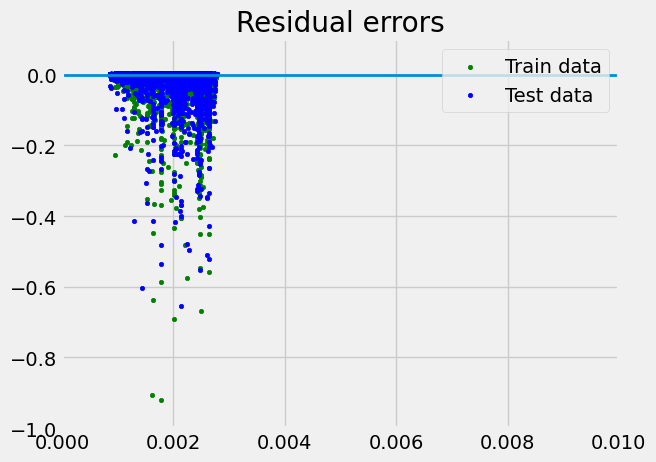

In [84]:
# splitting X and y into training and testing sets
X_train, X_test,\
    y_train, y_test = train_test_split(X, y,
                                       test_size=0.4,
                                       random_state=1)
 
# create linear regression object
reg = linear_model.LinearRegression()
 
# train the model using the training sets
result = reg.fit(X_train, y_train)
 
# regression coefficients
print('Coefficients: ', reg.coef_)
 
# variance score: 1 means perfect prediction
print('Variance score: {}'.format(reg.score(X_test, y_test)))
 
# plot for residual error
 
# setting plot style
plt.style.use('fivethirtyeight')
 
# plotting residual errors in training data
plt.scatter(reg.predict(X_train),
            reg.predict(X_train) - y_train,
            color="green", s=10,
            label='Train data')
 
# plotting residual errors in test data
plt.scatter(reg.predict(X_test),
            reg.predict(X_test) - y_test,
            color="blue", s=10,
            label='Test data')
 
# plotting line for zero residual error
plt.hlines(y=0, xmin=0, xmax=0.01, linewidth=2)

plt.xlim(0, 0.01) 
plt.ylim(-1, 0.1)
 
# plotting legend
plt.legend(loc='upper right')
 
# plot title
plt.title("Residual errors")
 
# method call for showing the plot
plt.show()

In [87]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              1379.
Date:                Tue, 22 Aug 2023   Prob (F-statistic):                   1.93e-300
Time:                        11:12:28   Log-Likelihood:                      4.3687e+05
No. Observations:              154122   AIC:                                 -8.737e+05
Df Residuals:                  154121   BIC:                                 -8.737e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0029   7.82e-05     37.131      0.000       0.003       0.003
==============================================================================
Omnibus:                   348587.989   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3461692739.185
Skew:                          21.525   Prob(JB):                         0.00
Kurtosis:                     735.942   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Check conditions for linear regression

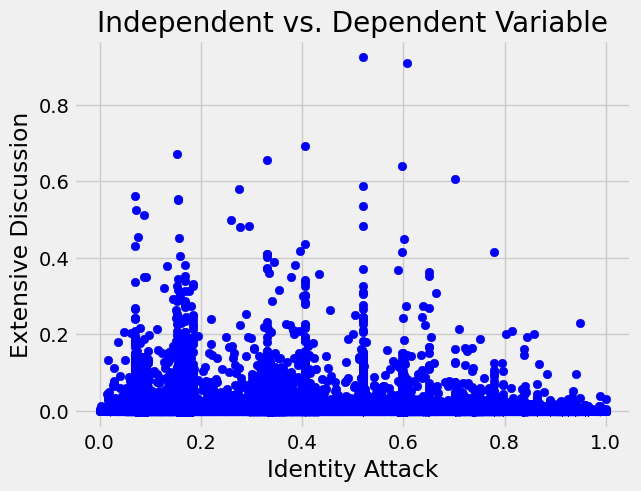

In [81]:
# 1. Linear relationship: not really linear
plt.scatter(X, extensive_discussion1, color='blue')
plt.xlabel('Identity Attack')
plt.ylabel('Extensive Discussion')
plt.title('Independent vs. Dependent Variable')
plt.show()

# 2. Little or no multi-collinearity
# 3. Little or no autocorrelation:
# 4. Homoscedasticity

Diagnostic shows linear regression is not allowed and a polynomial regression would better fit

In [82]:
model2 = np.poly1d(np.polyfit(X, y, 2))

line = np.linspace(0, 1, 1)

plt.scatter(X, y)
plt.plot(line, model2(line))
plt.show() 

TypeError: expected 1D vector for x

### create summary tables

In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154122 entries, 0 to 154121
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   commentID        154122 non-null  object 
 1   text             154122 non-null  object 
 2   publishedAt      154122 non-null  object 
 3   authorID         154122 non-null  object 
 4   likeCount        154122 non-null  int64  
 5   totalReplyCount  154122 non-null  int64  
 6   parentID         154122 non-null  object 
 7   videoID          154122 non-null  object 
 8   channelId        154122 non-null  object 
 9   username         154074 non-null  object 
 10  threat           154121 non-null  float64
 11  toxicity         154121 non-null  float64
 12  identity_attack  154121 non-null  float64
 13  insult           154121 non-null  float64
 14  severe_toxicity  154121 non-null  float64
 15  sentiment        154122 non-null  object 
 16  prob_pos         154122 non-null  floa

In [94]:
df_summary = pd.DataFrame(
    {
        "avg_gap": data["toxicity"].mean(),
        "max_gap": data["toxicity"].max(),
        "avg_time": data["toxicity"].mean(),
    }
)

# Display the summary
print(df_summary)

ValueError: If using all scalar values, you must pass an index